In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.insert(0, '..')

import random
from itertools import combinations

import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
import altair as alt

from paradeller.samples import load_samples
from paradeller.helper import (
    load_archive,
    save_to_pickle,
    read_from_pickle
)
from paradeller.dataprep import (
    tokenize,
    find_duplicates,
    filter_out_duplicates,
    filter_out_short,
    filter_out_oddballs,
    filter_out_oddballs_recursive,
    restructure_data,
    create_adj_list_by_word,
    create_adj_list_by_id
)
from paradeller.analysis import (
    find_matches,
    find_matches_for_start_pairs
)

In [2]:
def get_tweet(i):
    """Find tweet with given id"""
    try:
        return next(x for x in data if x["id"] == i)
    except StopIteration as e:
        print("Error: No tweet with that ID")
        return None

showlen = lambda data: print(f"Length: {len(data):,}")

## Get Data

In [4]:
#######################
USE_PICKLE = True
UPDATE_PICKLE = False
USE_SAMPLE = False
#######################



if USE_PICKLE:
    print("Loading real, processed data from pickle...")
    data, duplicates, adj_list_words, adj_list_ids = read_from_pickle()
else:
    if USE_SAMPLE:
        print("Loading unprocessed sample data...")
        data = load_samples()
    else:
        print("Loading unprocessed real data...")
        data = load_archive()
    
    showlen(data)
    print("Cleaning up data...")

    # remove too short
    print("> Remove too short")
    data = filter_out_short(data)
    showlen(data)
    
    # remove duplicate phrases
    print("> Remove duplicate phrases")
    duplicates = find_duplicates(data)
    data = filter_out_duplicates(data, duplicates)
    showlen(data)

    # remove oddballs (too few matches)
    print("> Recursively remove oddballs")
    data = filter_out_oddballs_recursive(data)
    showlen(data)

    print("Creating adjacency lists...")
    # make adj lists
    adj_list_words, adj_list_ids = restructure_data(data)
    
    if UPDATE_PICKLE:
        print("Saving new data to pickle...")
        save_to_pickle((data, duplicates, adj_list_words, adj_list_ids))
        
    
print("-"*50)
print("DONE\n")
stuff = {
    "data": data, "duplicates": duplicates, "adj_list_words": adj_list_words, "adj_list_ids": adj_list_ids
}
for k, v in stuff.items():
    print(f"{k:15} type: {type(v)}\tlen: {len(v):,}")

Loading real, processed data from pickle...
--------------------------------------------------
DONE

data            type: <class 'list'>	len: 106,092
duplicates      type: <class 'dict'>	len: 152,247
adj_list_words  type: <class 'dict'>	len: 12,547
adj_list_ids    type: <class 'dict'>	len: 106,092


## Find Tweets

### Sort by popularity of words

In [5]:
from statistics import mean

In [6]:
# sort tweet ids by avg popularity of its words
pop = []
for tweet_id, words in tqdm(adj_list_ids.items()):
    pop.append((
        tweet_id,
        mean([len(adj_list_words[word]) for word in words])
    ))
    
pop.sort(key=lambda x: x[1], reverse=True)

In [7]:
df = pd.DataFrame(pop, columns=['id', 'pop'])

df['pop'].describe()

count    106092.000000
mean       3682.031619
std        2327.263408
min           3.000000
25%        1901.486111
50%        3303.928571
75%        5166.472222
max       14778.000000
Name: pop, dtype: float64

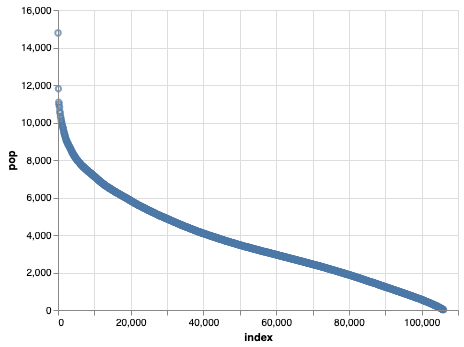

In [9]:
alt.Chart(df.reset_index()[::100]).mark_point().encode(
    x='index',
    y='pop',
)

## Run Search

In [12]:
some_ids = [x[0] for x in pop[:200]]
pairs = list(combinations(some_ids, 2))

print(f"{len(pairs):,}")

19,900


In [47]:
all_valid = find_matches_for_start_pairs(pairs, adj_list_ids, adj_list_words)

In [48]:
for pair, matches in all_valid.items():
    t1, t2 = pair
    stanza_start = [t1, t1, t2, t2]
    for match in matches:
        a, b = match
        stanza = stanza_start + [a, b]
        print("~"*50)
        for t in stanza:
            tweet = get_tweet(t)
            print(f"@{tweet['author']:20} {tweet['text']} ")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
@moonIightwitch       I need **** 
@moonIightwitch       I need **** 
@rnd__r               I want you 
@rnd__r               I want you 
@uqmozan              I need you!!! 
@Lovelli_liz          I want 🍑 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
@moonIightwitch       I need **** 
@moonIightwitch       I need **** 
@nxdmy                I hate you 
@nxdmy                I hate you 
@sataniclegend        i hate ******** 🤪 
@uqmozan              I need you!!! 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
@moonIightwitch       I need **** 
@moonIightwitch       I need **** 
@jnlsbb               I miss you. 
@jnlsbb               I miss you. 
@taurusjhs            I miss **** 
@uqmozan              I need you!!! 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
@moonIightwitch       I need **** 
@moonIightwitch       I need **** 
@Taken_By_DaBest      I want it 
@Taken_By_DaBest      I want it 
@kravekilo            I n

## More optimizations

### no common words

In [23]:
# start pairs should have no common words

# def no_common_words(pair):    
#     s1 = set(adj_list_ids[pair[0]])
#     s2 = set(adj_list_ids[pair[1]])
#     return len(s1.intersection(s2)) == 0

# pairs = [p for p in pairs if no_common_words(p)]
# comma_print(len(pairs))

### Parallelization??

In [25]:
from math import sqrt
from joblib import Parallel, delayed

from multiprocessing import Pool
import os

In [13]:
def find_matches_for_pair(p):
    return find_matches(p[0], p[1], adj_list_ids, adj_list_words)

In [14]:
with Pool(os.cpu_count()) as pool:
    res = pool.map(find_matches_for_pair, pairs)

NameError: name 'Pool' is not defined

In [ ]:
with Manager() as manager:
    d1 = adj_list_ids
    d2 = adj_list_words
    
    p = Process(target=f, args=(d, l))
    p.start()
    p.join()

In [ ]:
all_valid = [x for x in list(zip(pairs, res)) if x[1]]

In [ ]:
for pair, matches in all_valid:
    t1, t2 = pair
    stanza_start = [t1, t1, t2, t2]
    for match in matches:
        a, b = match
        stanza = stanza_start + [a, b]
        print("~"*50)
        for t in stanza:
            tweet = get_tweet(t)
            print(f"@{tweet['author']:20} {tweet['text']} ")

### Arrays??

In [15]:
import scipy.sparse as sp
from scipy.sparse import dok_matrix

In [16]:
x = len(adj_list_ids.keys())
y = len(adj_list_words.keys())

In [17]:
ids = np.array(list(adj_list_ids.keys()))

In [18]:
words = np.array(list(adj_list_words.keys()))

In [19]:
S = dok_matrix((len(ids), len(words)), dtype=np.bool)

In [21]:
for i in tqdm(range(len(ids))):
    for j in range(len(words)):
        val = ids[i] in adj_list_words[words[j]]
        S[i, j] = val

### Timing

Timing

- Takes ~73 ms

In [55]:
avg_run_ms = 73

res = []
for num_ids in tqdm([10, 100, 200, 500, 1000, 2000, 5000, 10_000]):
    some_ids = [
        random.choice(ids)
        for _ in range(num_ids)
    ]
    pairs = list(combinations(some_ids, 2))
    total_ms = len(pairs) * avg_run_ms
    seconds = total_ms / 1000
    
    res.append((num_ids, len(pairs), seconds))

In [56]:
df = pd.DataFrame(res, columns=['ids', 'pairs', 'seconds'])
df['hours'] = df['seconds'] / 60 / 60
df

,ids,pairs,seconds,hours
0,10,45,3.285,0.000913
1,100,4950,361.350,0.100375
2,200,19900,1452.700,0.403528
3,500,124750,9106.750,2.529653
4,1000,499500,36463.500,10.128750
5,2000,1999000,145927.000,40.535278
6,5000,12497500,912317.500,253.421528
7,10000,49995000,3649635.000,1013.787500


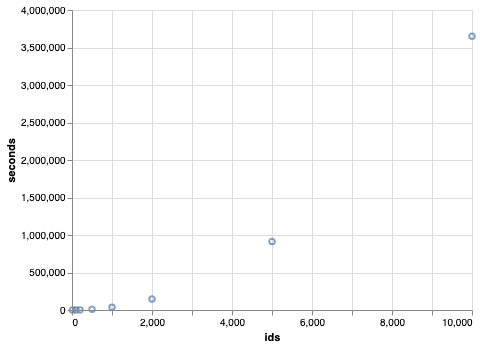

In [57]:
alt.Chart(df).mark_point().encode(
    x='ids',
    y='seconds'
)

In [124]:
some_pairs = [random.choice(pairs) for _ in range(10)]

In [123]:
d = {}

def timed(pair):
    a, b = pair
    res = %timeit -o find_matches(a, b, adj_list_ids, adj_list_words)
    d[pair] = (res.average * 1000)

In [117]:
# for p in tqdm(some_pairs):
#     timed(p)

In [88]:
df = pd.DataFrame(list(d.items()), columns=['pair', 'ms'])

In [91]:
df.describe()

,time (ms)
count,30.000000
mean,73.722072
std,33.391046
min,15.139419
25%,49.510464
50%,75.178153
75%,95.398927
max,149.660940


In [112]:
pair = df.sort_values(by='time (ms)').tail(1).pair.iloc[0]
pair

(1144711620683341824, 1144364140410146818)

In [115]:
a, b = pair

In [116]:
find_matches(a, b, adj_list_ids, adj_list_words, verbose=True)

stanza words : ['could', 'has', 'have', 'i', 'my', 'never', 'notifications', 'on', 'paige', 'to', 'work', 'you']
pot_ids      : 36183
filt pot_ids : 1


[]

In [55]:
a, b = random.choice(pairs)

In [70]:
res = %timeit -o find_matches(a, b, adj_list_ids, adj_list_words)

55.2 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [74]:
res.average

0.05515330764285733

In [75]:
0.05515330764285733 * 1000

55.15330764285733